# Characterisation of city districts in Amsterdam for prospective residents 

## Introduction / Business problem 

Problem: finding a suitable accomodation (to buy or rent) can be quite difficult in an unfamiliar city, certainly when the city is quite large. Finding the perfect accomodation is not only a matter of finding a house of the right size, price, and lay-out, but is also heavily dependent on the neighbourhood where it is located and the amenities nearby. While housing sites may offer a clear description of the house itself and possibly a short description of its neighbourhood it would be much more convenient to first decide on a neighbourhood before starting to look at specific houses. Of course, one can decide to visit the city before starting the actual house hunting process to get a feel for the different neighbourhoods, but this is not always possible or prefered (e.g due to high travel costs or long travel time, or currently due to travel-restrictions). An alternative might be to ask an estate agent for help, but this can be quite costly and is not always wanted since nowadays it is quite easy to buy or rent a house without the help of an estate agent. A tool which helps house hunters discover which neighbourhoods in their city of choice are best suited to their preferences may reduce the time needed to find a suitable house and may also improve satisfaction with their chosen accomodation.

## Data
To answer this problem I will make use of two datasources: Foursquare and the publicly available datasets provided by the municipality of Amsterdam (data.amsterdam.nl). Where Foursquare provides information on the location and type of venues, data.amsterdam.nl provides information on population statistics (e.g. age distribution, nationality, education, and income) as well as on housing (e.g. living area, and average value of housing). 

For statistical purposes Amsterdam can be divided into 8 neighbourhoods (coordinates can be downloaded from: https://maps.amsterdam.nl/open_geodata/). 
The venue data from Foursquare will be categorised into six groups: 
1. restaurants (including pubs and diners)
2. shopping (shops and stores)
3. markets
4. parks
5. sport (including gyms, pools, and yoga studios)
6. culture (theater, museums, music venues, opera houses, and other art)

These data will be combined with the data from data.amsterdam.nl on:
* age distribution
* nationality
* highest level of education 
* income
* size of living area
* average value of housing 

Together, this information will be used to describe the neighbourhoods and make recommendations for prospective house buyers/movers.

## Data analysis
### Data acquisition and clean-up

Import the needed libraries

In [1]:
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.preprocessing import MinMaxScaler

### Socio-economic and housing data Amsterdam
Open the necessary datasets (downloaded from data.amsterdam.nl saved as csv file)

In [2]:
data = pd.read_csv('2020_BBGA_1210.csv')
data.head()

,niveau,niveaunaam,SD,sdnaam,gebiedcode15,gebiedcodenaam,gebiednaam,GSD,jaar,BEVTOTAAL,...,SK017_KWETS34,SK017_KWETS34_P,SK1826_KWETS34,SK1826_KWETS34_P,SK2765_KWETS34,SK2765_KWETS34_P,SK66PLUS_KWETS34,SK66PLUS_KWETS34_P,SKACTI,SKACTI_1000INW
0,1,Amsterdam,S,Amsterdam,STAD,Amsterdam,Amsterdam,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Stadsdelen,A,A Centrum,A,A Centrum,Centrum,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Stadsdelen,B,B Westpoort,B,B Westpoort,Westpoort,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Stadsdelen,E,E West,E,E West,West,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,Stadsdelen,F,F Nieuw-West,F,F Nieuw-West,Nieuw-West,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# select only the districts ('stadsdelen') from the column 'niveaunaam'
# get names of indexes where column 'niveaunaam' is not 'stadsdelen' and remove these
index_names = data[data['niveaunaam'] != 'Stadsdelen'].index
data.drop(index_names, inplace=True)
data.head()

,niveau,niveaunaam,SD,sdnaam,gebiedcode15,gebiedcodenaam,gebiednaam,GSD,jaar,BEVTOTAAL,...,SK017_KWETS34,SK017_KWETS34_P,SK1826_KWETS34,SK1826_KWETS34_P,SK2765_KWETS34,SK2765_KWETS34_P,SK66PLUS_KWETS34,SK66PLUS_KWETS34_P,SKACTI,SKACTI_1000INW
1,2,Stadsdelen,A,A Centrum,A,A Centrum,Centrum,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Stadsdelen,B,B Westpoort,B,B Westpoort,Westpoort,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Stadsdelen,E,E West,E,E West,West,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,Stadsdelen,F,F Nieuw-West,F,F Nieuw-West,Nieuw-West,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,Stadsdelen,K,K Zuid,K,K Zuid,Zuid,NaN,2050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since most readers won't understand the Dutch variable names the table below will provide the English translations as well as a brief description of each category. The variables are incremental, meaning that var1 contains the lowest values and var5 the highest values.

In [4]:
# variables of interest with english translation
variables = [['income', 'fraction of households in each quintile of income', 'IINKQ1_P', 'IINKQ2_P', 'IINKQ3_P', 'IINKQ4_P', 'IINKQ5_P'],
            ['education', 'fraction of people with highest achieved education grouped as low, middle, and high', 'BEVOPLLAAG_P', 'BEVOPLMID_P', 'BEVOOPLHOOG_P'],
            ['size', 'fraction of houses with size of living area as grouped in 5 categories', 'WOPP0040_P', 'WOPP4060_P', 'WOPP6080_P', 'WOPP80100_P', 'WOPP100PLUS_P'],
            ['age', 'fraction of people in major age brackets', 'BEV0_18_P', 'BEV19_26_P', 'BEV27_65_P', 'BEV66PLUS_P'],
            ['value', 'average value of houses in the district', 'WWOZ_GEM'],
            ['nationality', 'nationality as Dutch, Western, or Non-Western', 'BEVAUTOCH_P', 'BEVWEST_P', 'BEVNW_P']]

pd.DataFrame(variables, columns = ['category', 'description', 'var1', 'var2', 'var3', 'var4', 'var5'])

,category,description,var1,var2,var3,var4,var5
0,income,fraction of households in each quintile of income,IINKQ1_P,IINKQ2_P,IINKQ3_P,IINKQ4_P,IINKQ5_P
1,education,fraction of people with highest achieved educa...,BEVOPLLAAG_P,BEVOPLMID_P,BEVOOPLHOOG_P,None,None
2,size,fraction of houses with size of living area as...,WOPP0040_P,WOPP4060_P,WOPP6080_P,WOPP80100_P,WOPP100PLUS_P
3,age,fraction of people in major age brackets,BEV0_18_P,BEV19_26_P,BEV27_65_P,BEV66PLUS_P,None
4,value,average value of houses in the district,WWOZ_GEM,None,None,None,None
5,nationality,"nationality as Dutch, Western, or Non-Western",BEVAUTOCH_P,BEVWEST_P,BEVNW_P,None,None


Next, create a new dataset that contains only the name of the districts and the variables of interest for the year 2018. 2018 is the most recent year with nearly all data available

In [5]:
# Create a new dataset with the year and name of the districts (jaar, gebiednaam) and the variables of interest
list_variables = ['jaar', 'gebiednaam', 'IINKQ1_P', 'IINKQ2_P', 'IINKQ3_P', 'IINKQ4_P', 'IINKQ5_P', 'BEVOPLLAAG_P', 'BEVOPLMID_P', 'BEVOPLHOOG_P', 'WOPP0040_P', 'WOPP4060_P', 'WOPP6080_P', 'WOPP80100_P', 'WOPP100PLUS_P', 'BEV0_18_P', 'BEV18_26_P', 'BEV27_65_P', 'BEV66PLUS_P', 'WWOZ_GEM', 'BEVAUTOCH_P', 'BEVWEST_P', 'BEVNW_P']
data_population = data[list_variables].copy()
data_population.shape

# select only the data for the year (jaar) 2018 
year = data_population[data_population['jaar'] != 2018].index
data_population.drop(year, inplace=True)
data_population = data_population.rename(columns={'jaar': 'year', 'gebiednaam': 'district'})
data_population = data_population[data_population.district != 'onbekend']

data_population.head(10)

,year,district,IINKQ1_P,IINKQ2_P,IINKQ3_P,IINKQ4_P,IINKQ5_P,BEVOPLLAAG_P,BEVOPLMID_P,BEVOPLHOOG_P,...,WOPP80100_P,WOPP100PLUS_P,BEV0_18_P,BEV18_26_P,BEV27_65_P,BEV66PLUS_P,WWOZ_GEM,BEVAUTOCH_P,BEVWEST_P,BEVNW_P
6269,2018,Centrum,30.0,20.0,17.0,13.0,20.0,12.0,25.0,62.0,...,13.8,18.2,11.3,15.0,60.9,13.4,468861.0,57.6,26.4,16.0
6270,2018,Westpoort,53.0,24.0,13.0,NaN,NaN,23.0,55.0,21.0,...,14.3,48.6,8.1,7.6,78.3,6.6,NaN,50.0,32.8,17.2
6271,2018,West,30.0,22.0,18.0,14.0,16.0,20.0,27.0,53.0,...,11.0,8.0,15.6,14.0,62.5,8.7,337770.0,49.8,19.5,30.7
6272,2018,Nieuw-West,29.0,23.0,18.0,15.0,14.0,32.0,36.0,32.0,...,24.0,20.2,22.2,15.9,51.6,11.6,237257.0,33.6,14.4,52.0
6273,2018,Zuid,26.0,20.0,17.0,14.0,23.0,15.0,25.0,60.0,...,13.3,20.1,15.2,13.8,57.6,14.1,470831.0,57.2,24.1,18.7
6274,2018,Oost,27.0,20.0,17.0,15.0,21.0,19.0,28.0,53.0,...,20.7,20.4,19.9,15.3,57.0,8.9,354958.0,50.9,17.3,31.8
6275,2018,Noord,30.0,24.0,18.0,15.0,14.0,34.0,37.0,29.0,...,23.4,14.0,22.2,12.1,52.6,14.2,244320.0,49.7,12.3,38.0
6276,2018,Zuidoost,36.0,23.0,19.0,13.0,9.0,35.0,42.0,23.0,...,30.5,15.8,21.5,15.7,53.6,10.5,175408.0,25.9,10.8,63.3


From the table above we can see that some data appears to be missing for Westpoort. IINKQ4_P, IINKQ5_P, and WWOZ_GEM have NaN. Since there are no values for IINKQ4_P and IINKQ5_P for the 2015-2018 we either have to conclude that these data have never been taken, or that the number of inhabitants with such a high income is negligible in this district. 

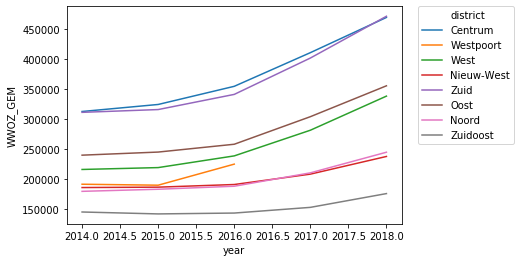

In [6]:
list_wwoz = ['jaar', 'WWOZ_GEM', 'gebiednaam']
data_wwoz = data[list_wwoz].copy()
data_wwoz =data_wwoz[288:333]
data_wwoz = data_wwoz[data_wwoz.gebiednaam != 'onbekend']
data_wwoz = data_wwoz.rename(columns={'gebiednaam': 'district', 'jaar':'year'})

sns.lineplot(x='year', y='WWOZ_GEM', data=data_wwoz, hue='district')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The WWOZ_GEM of Westpoort is missing for 2017 and 2018. From the figure above we can see that this value has been rising in all districts from 2015. By using the average ratio of increase in house values of the other districts and the house value of Westpoort in 2016 we can make an estimation of the house value of Westpoort in 2018.

In [7]:
# get the house values for 2018 and place them in a list
data_2018 = data_wwoz[data_wwoz['year'] == 2018]
data_2018 = data_2018[data_2018.district != 'Westpoort']
list_2018 = data_2018['WWOZ_GEM'].tolist()

# get the house values for 2016 and place them in a list
data_2016 = data_wwoz[data_wwoz['year'] == 2016]
westpoort_2016 = float(data_2016.loc[data_2016.district == 'Westpoort', 'WWOZ_GEM']) # house value westpoort in 2016
data_2016 = data_2016[data_2016.district != 'Westpoort']
list_2016 = data_2016['WWOZ_GEM'].tolist()

# calculate the ratio between 2018 and 2016 for each district and add this to a list
list_ratio = []
for new, old in zip(list_2018, list_2016):
    ratio = new/old
    list_ratio.append(ratio)
# calculate the average ratio
average_ratio = sum(list_ratio)/len(list_ratio)
# estimate the house value of Westpoort in 2018
westpoort_2018 = average_ratio * westpoort_2016
print('estimated WWOZ_GEM of Westpoort in 2018:', westpoort_2018)


estimated WWOZ_GEM of Westpoort in 2018: 297483.73766352684


In [8]:
# add estimated value Westpoort to dataframe
data_wwoz.loc[(data_wwoz['year'] == 2018) & (data_wwoz['district'] == 'Westpoort'), 'WWOZ_GEM'] = westpoort_2018
data_wwoz.head()

,year,WWOZ_GEM,district
6269,2018,468861.000000,Centrum
6270,2018,297483.737664,Westpoort
6271,2018,337770.000000,West
6272,2018,237257.000000,Nieuw-West
6273,2018,470831.000000,Zuid


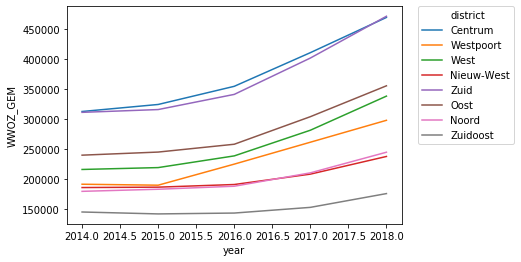

In [9]:
# re-plot the figure with the estimated house value of Westpoort in 2018
sns.lineplot(x='year', y='WWOZ_GEM', data=data_wwoz, hue='district')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Geographical data and mapping

In [10]:
coordinates = pd.read_csv('GEBIED_STADSDELEN.csv', delimiter=';')
coordinates.head()

,OBJECTNUMMER,Stadsdeel_code,Stadsdeel,Opp_m2,WKT_LNG_LAT,WKT_LAT_LNG,LNG,LAT,Unnamed: 8
0,1,A,Centrum,8043500,"POLYGON((4.932973 52.3704,4.932942 52.370539,4...","POLYGON((52.3704 4.932973,52.370539 4.932942,5...",4.903712,52.373297,NaN
1,2,B,Westpoort,28991600,"POLYGON((4.885861 52.39937,4.882702 52.401695,...","POLYGON((52.39937 4.885861,52.401695 4.882702,...",4.807319,52.411465,NaN
2,3,E,West,10629900,"POLYGON((4.895084 52.388684,4.894675 52.389933...","POLYGON((52.388684 4.895084,52.389933 4.894675...",4.865216,52.377879,NaN
3,4,F,Nieuw-West,38015500,"POLYGON((4.850498 52.364232,4.850459 52.365189...","POLYGON((52.364232 4.850498,52.365189 4.850459...",4.802676,52.363591,NaN
4,5,K,Zuid,17274000,"POLYGON((4.914989 52.342139,4.914945 52.342421...","POLYGON((52.342139 4.914989,52.342421 4.914945...",4.866063,52.341721,NaN


In [11]:
# let's clean this up by removing the unnecessary columns (objectnummer, stadsdeel_code, opp_m2, unnamed)
coordinates = coordinates.drop('OBJECTNUMMER', axis=1).drop('Stadsdeel_code', axis=1).drop('Opp_m2', axis=1).drop('Unnamed: 8', axis=1)
# change the column names to english
coordinates = coordinates.rename(columns ={'Stadsdeel': 'district', 'WKT_LNG_LAT': 'borders_lng_lat', 'WKT_LAT_LNG': 'borders_lat_lng'})
coordinates.head()

,district,borders_lng_lat,borders_lat_lng,LNG,LAT
0,Centrum,"POLYGON((4.932973 52.3704,4.932942 52.370539,4...","POLYGON((52.3704 4.932973,52.370539 4.932942,5...",4.903712,52.373297
1,Westpoort,"POLYGON((4.885861 52.39937,4.882702 52.401695,...","POLYGON((52.39937 4.885861,52.401695 4.882702,...",4.807319,52.411465
2,West,"POLYGON((4.895084 52.388684,4.894675 52.389933...","POLYGON((52.388684 4.895084,52.389933 4.894675...",4.865216,52.377879
3,Nieuw-West,"POLYGON((4.850498 52.364232,4.850459 52.365189...","POLYGON((52.364232 4.850498,52.365189 4.850459...",4.802676,52.363591
4,Zuid,"POLYGON((4.914989 52.342139,4.914945 52.342421...","POLYGON((52.342139 4.914989,52.342421 4.914945...",4.866063,52.341721


While the coordinates for the district borders can be obtained from the table above this is rather laborious since the data has been saved as one long string and will have to be formatted to a GeoJSON file before it can be used in folium. Luckily, the border coordinates can also be downloaded as a JSON file which can be formatted as a GeoJSON file. There are several website which can do this for you so I went ahead and saved the GeoJSON file.
Let's first create a map of Amsterdam and add in markers for each of the districts.

In [12]:
latitude = 52.370216
longitude = 4.895168
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, district in zip(coordinates['LAT'], coordinates['LNG'], coordinates['district']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_amsterdam)
    
map_amsterdam

Next, add the borders of the districts. The coordinates in the geoJSON file are given as longitude, latitude, but folium needs these coordinates in the reverse order (lat-lng) so the first step is to reverse the order in the GeoJSON file.

In [13]:
with open('GEBIED_STADSDELEN.geojson') as f:
  data = json.load(f)

def flip_geojson_coordinates(geo):
    if isinstance(geo, dict):
        for k, v in geo.items():
            if k == "coordinates":
                z = np.asarray(geo[k])
                f = z.flatten()
                geo[k] = np.dstack((f[1::2], f[::2])).reshape(z.shape).tolist()
            else:
                flip_geojson_coordinates(v)
    elif isinstance(geo, list):
        for k in geo:
            flip_geojson_coordinates(k)

flip_geojson_coordinates(data)

In [14]:
folium.GeoJson(data, name='geojson').add_to(map_amsterdam)
map_amsterdam

From the newly created map we can see that the coordinates for the districts Oost, Zuid, and Centrum are not nicely in the middle of the districts, or rather, they are in the average middle of the districts but close to a border due to the irregular shapes of the districts. Normally, this wouldn't be a problem but since the location data obtained via Foursquare is based on a circle with the middle point as the coordinate of the districts is could lead to misleading data. While the marker for Noord is nicely in the middle of the district, half of the district is composed of farmland which gives little information on the presence of venues in the city itself. To prevent these biases I will set new coordinates for Foursquare that will result in a more representative sampling of the district. 
* Centrum: 52.369677, 4.894306
* Zuid: 52.344153, 4.877072
* Oost: 52.352438, 4.940266
* Noord:52.398997, 4.921745

Due to the better placement of the district centre coordinates it is also possible to increase the radius used in Foursquare in later analysis.

In [15]:
adj_coordinates = coordinates.copy()
adj_coordinates.loc[(adj_coordinates['district'] == 'Centrum'), 'LNG'] = 4.894306
adj_coordinates.loc[(adj_coordinates['district'] == 'Centrum'), 'LAT'] = 52.369677
adj_coordinates.loc[(adj_coordinates['district'] == 'Zuid'), 'LNG'] = 4.877072
adj_coordinates.loc[(adj_coordinates['district'] == 'Zuid'), 'LAT'] = 52.344153
adj_coordinates.loc[(adj_coordinates['district'] == 'Oost'), 'LNG'] = 4.940266
adj_coordinates.loc[(adj_coordinates['district'] == 'Oost'), 'LAT'] = 52.352438
adj_coordinates.loc[(adj_coordinates['district'] == 'Noord'), 'LNG'] = 4.921745
adj_coordinates.loc[(adj_coordinates['district'] == 'Noord'), 'LAT'] = 52.398997

adj_coordinates = adj_coordinates.drop('borders_lng_lat', axis=1).drop('borders_lat_lng', axis=1)
adj_coordinates.head(10)

,district,LNG,LAT
0,Centrum,4.894306,52.369677
1,Westpoort,4.807319,52.411465
2,West,4.865216,52.377879
3,Nieuw-West,4.802676,52.363591
4,Zuid,4.877072,52.344153
5,Oost,4.940266,52.352438
6,Noord,4.921745,52.398997
7,Zuidoost,4.975444,52.304654


In [16]:
# create new map
adj_map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=12)

# add new markers to map
for lat, lng, district in zip(adj_coordinates['LAT'], adj_coordinates['LNG'], adj_coordinates['district']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(adj_map_amsterdam)
    
# add borders to map
folium.GeoJson(data, name='geojson').add_to(adj_map_amsterdam)
adj_map_amsterdam

## obtain & clean-up data Foursquare

# REMOVE PASSWORD AND ID BEFORE POSTING TO GITHUB!!!

In [ ]:
# define Foursquare credentials 
CLIENT_ID = input('please give your client ID:')
CLIENT_SECRET = input('please give your password:')

VERSION = '20180605' # Foursquare API version
LIMIT = 900 # A default Foursquare API limit value


In [18]:
# explore districts in Amsterdam

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# run the function 'getNearbyVenues' for each district and create a new dataframe called venues_amsterdam
venues_amsterdam = getNearbyVenues(names = adj_coordinates['district'],
                                latitudes = adj_coordinates['LAT'],
                                longitudes = adj_coordinates['LNG'])

Centrum
Westpoort
West
Nieuw-West
Zuid
Oost
Noord
Zuidoost


In [20]:
# check size of the new dataframe
print(venues_amsterdam.shape)
venues_amsterdam.head()

(509, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centrum,52.369677,4.894306,Gartine,52.369157,4.891615,Breakfast Spot
1,Centrum,52.369677,4.894306,Sofitel Legend The Grand Amsterdam,52.371093,4.895410,Hotel
2,Centrum,52.369677,4.894306,P.G.C. Hajenius,52.369665,4.891971,Smoke Shop
3,Centrum,52.369677,4.894306,Hotel V,52.371125,4.893665,Hotel
4,Centrum,52.369677,4.894306,De Laatste Kruimel,52.369220,4.892810,Bakery


In [21]:
# check how many venues were returned for each district
venues_amsterdam.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Centrum,100,100,100,100,100,100
Nieuw-West,47,47,47,47,47,47
Noord,49,49,49,49,49,49
Oost,85,85,85,85,85,85
West,100,100,100,100,100,100
Westpoort,4,4,4,4,4,4
Zuid,100,100,100,100,100,100
Zuidoost,24,24,24,24,24,24


In [22]:
# how many unique categories can be curated from the returned districts?
print('There are {} unique categories.'.format(len(venues_amsterdam['Venue Category'].unique())))

There are 152 unique categories.


In [23]:
# analyse each district
# one hot encoding
onehot_amsterdam = pd.get_dummies(venues_amsterdam[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
onehot_amsterdam['District'] = venues_amsterdam['District']

# move district column to the first column
fixed_columns = [onehot_amsterdam.columns[-1]] + list(onehot_amsterdam.columns[:-1])
onehot_amsterdam = onehot_amsterdam[fixed_columns]

onehot_amsterdam.head()

,District,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Theater,Toy / Game Store,Track,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Centrum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Centrum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Centrum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Centrum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Centrum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
grouped_amsterdam = onehot_amsterdam.groupby('District').sum().reset_index()
grouped_amsterdam.head()

,District,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Theater,Toy / Game Store,Track,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Centrum,0,0,1,1,0,1,0,0,0,...,1,0,0,0,0,0,1,0,2,0
1,Nieuw-West,0,0,0,0,1,0,0,0,0,...,1,0,1,0,3,0,0,0,0,0
2,Noord,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,Oost,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,2,0,0,0,0
4,West,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,2,0,0,0,1


In [25]:
# What venues does Foursquare return?
list(onehot_amsterdam.columns)

['District',
 'Arcade',
 'Argentinian Restaurant',
 'Art Museum',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Workshop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bar',
 'Baseball Field',
 'Beer Bar',
 'Beer Store',
 'Bistro',
 'Bookstore',
 'Bowling Alley',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Burger Joint',
 'Bus Station',
 'Bus Stop',
 'Café',
 'Canal',
 'Candy Store',
 'Caribbean Restaurant',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comedy Club',
 'Comfort Food Restaurant',
 'Convenience Store',
 'Creperie',
 'Dance Studio',
 'Deli / Bodega',
 'Department Store',
 'Design Studio',
 'Dessert Shop',
 'Diner',
 'Discount Store',
 'Distribution Center',
 'Drugstore',
 'Dutch Restaurant',
 'Electronics Store',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Farm',
 'Farmers Market',
 'Fast Food Restaurant',
 'Fish Market',
 'Flower Shop'

In [26]:
# Combine venues to the predefined categories
list_restaurant = ['Argentinian Restaurant', 'Asian Restaurant', 'BBQ Joint', 'Beer Bar', 'Beer Garden', 'Bistro', 'Breakfast Spot', 'Burger Joint', 'Café', 'Caribbean Restaurant', 'Chinese Restaurant', 'Cocktail Bar', 'Coffee Shop', 'Comfort Food Restaurant','Creperie', 'Diner', 'Dutch Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Food Court', 'Food Truck', 'French Restaurant', 'Fried Chicken Joint', 'Friterie', 'Gastropub', 'Greek Restaurant', 'Indian Restaurant', 'Indonesian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Juice Bar', 'Lebanese Restaurant', 'Mediterranean Restaurant', 'Middle Eastern Restaurant', 'Pizza Place', 'Pub', 'Restaurant', 'Salad Place', 'Sandwich Place', 'Scandinavian Restaurant', 'Seafood Restaurant', 'Snack Place', 'Steakhouse', 'Sushi Restaurant', 'Thai Restaurant', 'Turkish Restaurant', 'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant']
list_shopping = ['Arts & Crafts Store', 'Bookstore', 'Bridal Shop', 'Clothing Store', 'Department Store', 'Discount Store', 'Drugstore', 'Electronics Store', 'Flower Shop', 'Furniture / Home Store', 'Gift Shop', 'Paper / Office Supplies Store', 'Pharmacy', 'Record Shop', 'Shopping Mall', 'Shopping Plaza', 'Smoke Shop', 'Sporting Goods Shop', 'Toy / Game Store', 'Women\'s Store']
list_markets = ['Farmers Market', 'Fish Market', 'Market']
list_parks = ['Lake', 'Park', 'Trail', 'Nature Preserve']
list_sport = ['Arcade', 'Athletics & Sports', 'Baseball Field', 'Bowling Alley', 'Dance Studio', 'Golf Course', 'Gym', 'Gym / Fitness Center',  'Gym Pool', 'Gymnastics Gym', 'Playground', 'Pool', 'Soccer Field', 'Spa', 'Sports Club', 'Stadium', 'Tennis Court', 'Yoga Studio']
list_culture = ['Art Museum', 'Arts & Entertainment', 'Church', 'Comedy Club', 'History Museum', 'Movie Theater', 'Museum', 'Music School', 'Music Venue', 'Nightclub', 'Opera House', 'Public Art', 'Theater']

grouped_amsterdam['Restaurant'] = grouped_amsterdam[[c for c in grouped_amsterdam.columns if c in list_restaurant]].sum(axis=1)
grouped_amsterdam['Shopping'] = grouped_amsterdam[[c for c in grouped_amsterdam.columns if c in list_shopping]].sum(axis=1)
grouped_amsterdam['Markets'] = grouped_amsterdam[[c for c in grouped_amsterdam.columns if c in list_markets]].sum(axis=1)
grouped_amsterdam['Parks'] = grouped_amsterdam[[c for c in grouped_amsterdam.columns if c in list_parks]].sum(axis=1)
grouped_amsterdam['Sport'] = grouped_amsterdam[[c for c in grouped_amsterdam.columns if c in list_sport]].sum(axis=1)
grouped_amsterdam['Culture'] = grouped_amsterdam[[c for c in grouped_amsterdam.columns if c in list_culture]].sum(axis=1)
grouped_amsterdam.head()

,District,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio,Shopping,Markets,Parks,Sport,Culture
0,Centrum,0,0,1,1,0,1,0,0,0,...,0,1,0,2,0,12,1,0,0,8
1,Nieuw-West,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,10,0,1,7,2
2,Noord,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,7,2,2,6,2
3,Oost,0,0,0,0,0,1,1,0,0,...,2,0,0,0,0,9,2,2,13,3
4,West,1,0,0,0,0,0,0,0,1,...,2,0,0,0,1,5,1,2,9,2


In [27]:
# create new dataframe with only the districts and categories
list_categories = ['District', 'Restaurant', 'Shopping', 'Markets', 'Parks', 'Sport', 'Culture']
categories_amsterdam = grouped_amsterdam[list_categories].copy()
categories_amsterdam.head(10)

,District,Restaurant,Shopping,Markets,Parks,Sport,Culture
0,Centrum,37,12,1,0,0,8
1,Nieuw-West,11,10,0,1,7,2
2,Noord,13,7,2,2,6,2
3,Oost,33,9,2,2,13,3
4,West,54,5,1,2,9,2
5,Westpoort,1,0,0,0,0,0
6,Zuid,52,6,0,1,5,3
7,Zuidoost,4,5,0,1,1,1


# Main analysis

### Age distribution across the eight districts of Amsterdam

Text(0, 0.5, 'fraction of persons')

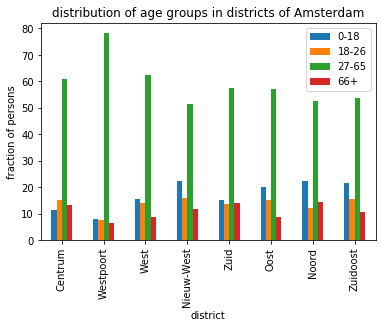

In [28]:
# create a small dataframe specific for age
age = data_population[['district', 'BEV0_18_P', 'BEV18_26_P', 'BEV27_65_P', 'BEV66PLUS_P']].copy()
# change column names
age = age.rename(columns = {'BEV0_18_P': '0-18', 'BEV18_26_P': '18-26', 'BEV27_65_P': '27-65', 'BEV66PLUS_P': '66+'})
age = age.set_index('district')

y_age = 'fraction of persons'
title_age = 'distribution of age groups in districts of Amsterdam'

ax = age.plot(kind = 'bar', title=title_age)
ax.set_ylabel(y_age)

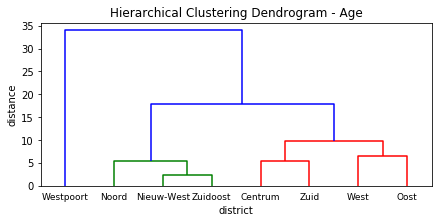

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
age_2 = age.astype(int)

# generate the linkage matrix
Z = linkage(age_2, 'ward')

# calculate full dendrogram
plt.figure(figsize=(7, 3))
plt.title('Hierarchical Clustering Dendrogram - Age')
plt.xlabel('district')
plt.ylabel('distance')
dendrogram(Z, color_threshold=15,
    orientation = 'top',
    leaf_font_size=9,  
    labels = age_2.index
   )
plt.show()

### Distribution of nationality across districts of Amsterdam

Text(0, 0.5, 'fraction of persons')

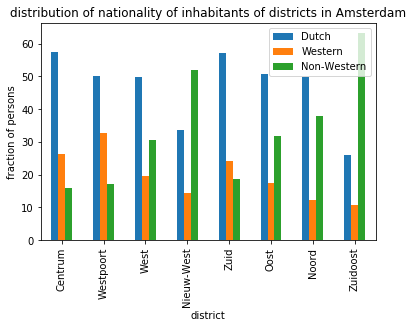

In [30]:
nationality = data_population[['district', 'BEVAUTOCH_P', 'BEVWEST_P', 'BEVNW_P']].copy()
nationality = nationality.rename(columns={'BEVAUTOCH_P': 'Dutch', 'BEVWEST_P': 'Western', 'BEVNW_P': 'Non-Western'})
nationality = nationality.set_index('district')
y_nationality = 'fraction of persons'
title_nationality = 'distribution of nationality of inhabitants of districts in Amsterdam'
ax = nationality.plot(kind='bar', title=title_nationality)
ax.set_ylabel(y_nationality)

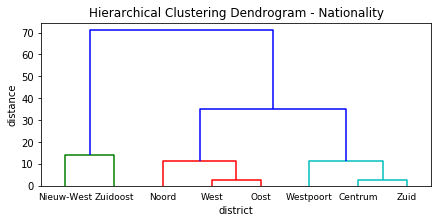

In [31]:
nationality_2 = nationality.astype(int)

# generate the linkage matrix
Z = linkage(nationality_2, 'ward')

# calculate full dendrogram
plt.figure(figsize=(7, 3))
plt.title('Hierarchical Clustering Dendrogram - Nationality')
plt.xlabel('district')
plt.ylabel('distance')
dendrogram(Z, color_threshold=15,
    orientation = 'top',
    leaf_font_size=9,  
    labels = nationality_2.index
   )
plt.show()

### Distribution of education levels across districts of Amsterdam

Text(0, 0.5, 'fraction of persons')

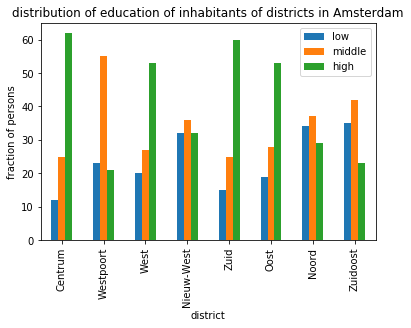

In [32]:
education = data_population[['district', 'BEVOPLLAAG_P', 'BEVOPLMID_P', 'BEVOPLHOOG_P']].copy()
education = education.rename(columns={'BEVOPLLAAG_P': 'low', 'BEVOPLMID_P': 'middle', 'BEVOPLHOOG_P': 'high'})
education = education.set_index('district')
y_education = 'fraction of persons'
title_education = 'distribution of education of inhabitants of districts in Amsterdam'
ax = education.plot(kind='bar', title=title_education)
ax.set_ylabel(y_education)

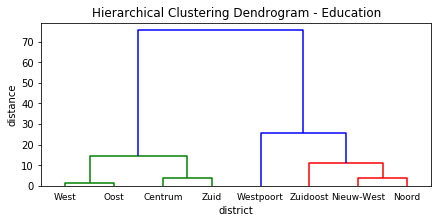

In [33]:
education_2 = education.astype(int)

# generate the linkage matrix
Z = linkage(education_2, 'ward')

# calculate full dendrogram
plt.figure(figsize=(7, 3))
plt.title('Hierarchical Clustering Dendrogram - Education')
plt.xlabel('district')
plt.ylabel('distance')
dendrogram(Z, color_threshold=15,
    orientation = 'top',
    leaf_font_size=9,  
    labels = education_2.index
   )
plt.show()

### Distribution of income levels across districts of Amsterdam

Text(0, 0.5, 'fraction of persons')

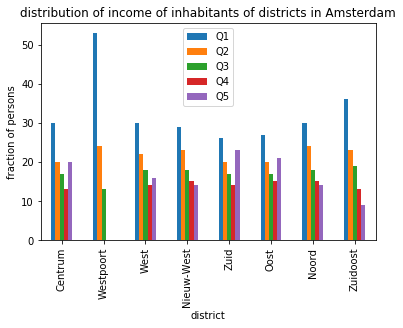

In [34]:
income = data_population[['district', 'IINKQ1_P', 'IINKQ2_P', 'IINKQ3_P', 'IINKQ4_P', 'IINKQ5_P']].copy()
income = income.rename(columns = {'IINKQ1_P': 'Q1', 'IINKQ2_P': 'Q2', 'IINKQ3_P': 'Q3', 'IINKQ4_P': 'Q4', 'IINKQ5_P': 'Q5'})
income = income.set_index('district')
y_income = 'fraction of persons'
title_income = 'distribution of income of inhabitants of districts in Amsterdam'
ax = income.plot(kind='bar', title=title_income)
ax.set_ylabel(y_income)

# Note: Q1 is the lowest quantile (lowest income) and Q5 the highest quantile

Due to the missing data for Westpoort it is not possible to make a dendrogram

### Distribution of house size across districts of Amsterdam

Text(0, 0.5, 'fraction of persons')

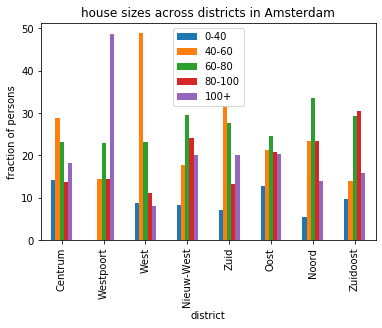

In [35]:
living_area = data_population[['district', 'WOPP0040_P', 'WOPP4060_P', 'WOPP6080_P', 'WOPP80100_P', 'WOPP100PLUS_P' ]].copy()
living_area = living_area.rename(columns={'WOPP0040_P': '0-40', 'WOPP4060_P': '40-60', 'WOPP6080_P': '60-80', 'WOPP80100_P' : '80-100', 'WOPP100PLUS_P': '100+'})
living_area = living_area.set_index('district')
y_living_area = 'fraction of persons'
title_living_area = 'house sizes across districts in Amsterdam'
ax = living_area.plot(kind='bar', title=title_living_area)
ax.set_ylabel(y_living_area)

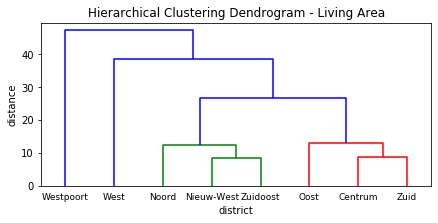

In [36]:
living_area_2 = living_area.astype(int)

# generate the linkage matrix
Z = linkage(living_area_2, 'ward')

# calculate full dendrogram
plt.figure(figsize=(7, 3))
plt.title('Hierarchical Clustering Dendrogram - Living Area')
plt.xlabel('district')
plt.ylabel('distance')
dendrogram(Z, color_threshold=15,
    orientation = 'top',
    leaf_font_size=9, 
    labels = living_area_2.index
   )
plt.show()

### Average house values across districts of Amsterdam

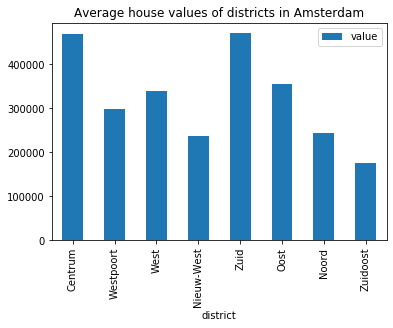

In [37]:
plot_wwoz = data_wwoz.copy()
plot_wwoz = plot_wwoz.loc[plot_wwoz['year'] == 2018]
plot_wwoz = plot_wwoz[['district', 'WWOZ_GEM']]
plot_wwoz = plot_wwoz.rename(columns={'WWOZ_GEM': 'value'})
plot_wwoz = plot_wwoz.set_index('district')
ax = plot_wwoz.plot(kind = 'bar', title = 'Average house values of districts in Amsterdam')

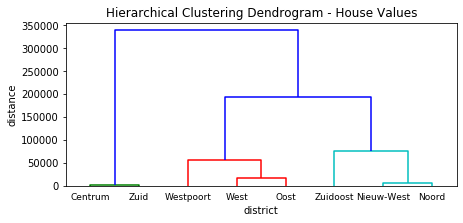

In [38]:
plot_wwoz_2 = plot_wwoz.astype(int)

# generate the linkage matrix
Z = linkage(plot_wwoz_2, 'ward')

# calculate full dendrogram
plt.figure(figsize=(7, 3))
plt.title('Hierarchical Clustering Dendrogram - House Values')
plt.xlabel('district')
plt.ylabel('distance')
dendrogram(Z, color_threshold=80000,
    orientation = 'top',
    leaf_font_size=9,  
    labels = plot_wwoz_2.index
   )
plt.show()

### Venue data

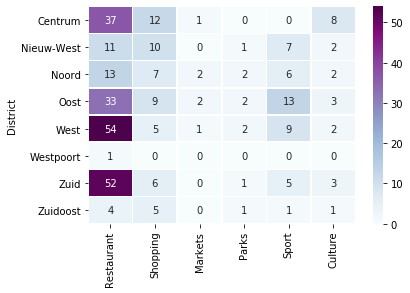

In [39]:
# Let's create a heatmap to visualise the distribution of the venue categories across the districts. 
categories_amsterdam = categories_amsterdam.set_index('District')
ax = sns.heatmap(categories_amsterdam, linewidth=0.5, cmap='BuPu', annot=True)
plt.show()

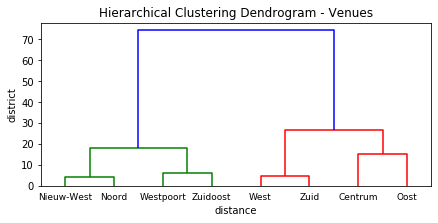

In [40]:
categories_amsterdam_2 = categories_amsterdam.astype(int)

# generate the linkage matrix
Z = linkage(categories_amsterdam_2, 'ward')

# calculate full dendrogram
plt.figure(figsize=(7, 3))
plt.title('Hierarchical Clustering Dendrogram - Venues')
plt.xlabel('distance')
plt.ylabel('district')
dendrogram(Z, color_threshold=60,
    orientation = 'top',
    leaf_font_size=9,  # font size for the cell line labels
    labels = categories_amsterdam_2.index
   )
plt.show()

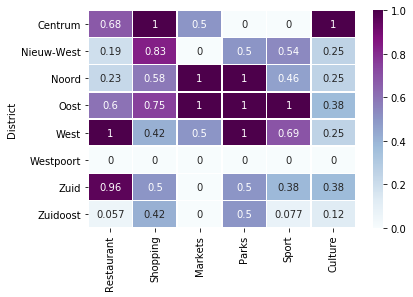

In [41]:
# Due to the large number of restaurants it is very diffucult to interpret the distribution of the venues in the other categories. 
# lets normalise the data for easier interpretation
districts = ['Centrum', 'Nieuw-West', 'Noord', 'Oost', 'West', 'Westpoort', 'Zuid', 'Zuidoost']
normal_amsterdam = categories_amsterdam[['Restaurant', 'Shopping', 'Markets', 'Parks', 'Sport', 'Culture']].copy()
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(normal_amsterdam) 
normal_amsterdam.loc[:,:] = scaled_values
normal_amsterdam.insert(0, 'District', districts , True)
normal_amsterdam = normal_amsterdam.set_index('District')
normal_amsterdam.head(10)

ax = sns.heatmap(normal_amsterdam, linewidth=0.5, cmap='BuPu', annot=True)
plt.show()

## Final map

In [43]:
# create new map of Amsterdam
final_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add district borders to map
folium.GeoJson(data, name='geojson').add_to(final_map)

# text for markers
Centrum = 'Centrum is the city centre and is therefore unsurprisingly characterised by a high number of restaurants, shops, and culture-related venues. The house sizes are mixed and vary from very small to very large, though house prices are generally high. The population is generally highly educated and consists of people of all ages. Most inhabitants are of either Dutch or Western parentage. '
Westpoort = 'Westpoort is located at the edge of Amsterdam and is characterised by a lot of industry which is reflected by the lack of venues in this district. House prices are in the mid-range, but house size are generally large. This district contains most people of the working population (80%), of which a large fraction has a mid-level education. Inhabitants are mainly of Dutch or Western parentage. '
West = 'Westpoort is located at the edge of Amsterdam and is characterised by a lot of industry which is reflected by the lack of venues in this district. House prices are in the mid-range, but house size are generally large. This district contains most people of the working population (80%), of which a large fraction has a mid-level education. Inhabitants are mainly of Dutch or Western parentage. '
N_West = 'Nieuw-West is one of the newer districts as its name suggests (‘nieuw’ = ‘new’) and is characterised by the presence of many young families with children. The district has a large non-Western population with a mixed level of education similar to that of the entire population of the Netherlands. House values are low compared to the rest of the city, though this does not mean that the houses are small since the majority of the houses are in the mid-range. The number of restaurants, shops, and culture-related venues is relatively low, though there are multiple locations for sport. '
Zuid = 'Zuid is known as the financial district of Amsterdam. With a swift connection to the major airport of the Netherlands, the presence of the campus of one of the two universities in the city, as well as many restaurants and culture-related venues it is not surprising that this is an expensive place to live. Similarly, it is unsurprising that most inhabitants have a high level of education. House sizes range from very small to very large and offer therefore space for people of all age groups. The majority of the population is of either Dutch or Western parentage.'
Noord = 'Noord is the most northern district of Amsterdam and a large area of the district consists of farmland. The city part of the district is characterised by mid-range size houses which are relatively cheap. The population is sports large fractions of people of Dutch, Western, and non-Western parentage and contains many young families with children. Education levels are mixed. There are few venues. '
Oost = 'Oost is comparable to Centrum in terms of the number of restaurants and shopping venues, but it contains considerably more venues for sport. Just as in Centrum, the house size vary from very small to very large though the house values are lower in the mid-range. The population is mixed with large fractions of people of Dutch, Western, and non-Western parentage with a mixed education level. The population spans people of all age groups. '
Z_Oost = 'Zuidoost is separated from the main city by the town Diemen. This district hosts one of the city’s universities but boasts few other venues. However, the house values are low while the house size are in the mid-range making this an affordable yet attractive place to live. Most inhabitants are of non-Western parentage and there is a large fraction of young families with children. '
list_markers = [Centrum, Westpoort, West, N_West, Zuid, Noord, Oost, Z_Oost]

# add text to dataframe containing the coordinates
adj_coordinates = adj_coordinates.join(pd.DataFrame({'description': list_markers}))
adj_coordinates.head()

# add markers to map    
for lat, lng, district in zip(adj_coordinates['LAT'], adj_coordinates['LNG'], adj_coordinates['description']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(final_map)
    
final_map